In [1]:
import mezo
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy
import scipy.sparse as ss
from scipy.sparse import linalg as sl

### Good Resources
- [Notes by László Oroszlány](http://oroszl.web.elte.hu/mezo/OL_lecture_notes-1.pdf)
- [Non Equilibrium Green’s Functions for Dummies](https://arxiv.org/pdf/cond-mat/0210519.pdf)
- [Green’s Functions in Quantum Physics, E.N. Economou (Springer, 2005)]()
- [Theory of Quantum Transport at Nanoscale, Dmitry A. Ryndyk Chapter 3. (Springer, 2016)]()

## Task: BHZ model dirty edge local density
The Hamiltonian is
$$
\hat H_{BHZ} = \begin{bmatrix}
\hat H_{QWZ} & 0 \\
0 & \hat H^{\dagger}_{QWZ}
\end{bmatrix}.
$$
In QWZ, we have
$$
\hat T_{x/y} = \frac{\hat\sigma_z + i\hat\sigma_{x/y}}{2}, \hat U = \Delta\hat\sigma_z
$$
My tasks:
- Calculate the site resolved local density of states for a BHZ wire with a scatterer located at the edge of the sample.
- Take simple potetial scattering i.e. $V\propto I_4$
- Take completely random scatterer.

The on-site Hamiltonian for a single site is
$$
\hat H_0 = 
\begin{bmatrix}
\Delta\sigma_z & 0 \\
0 & \Delta\sigma_z
\end{bmatrix},
$$
the hopping elements are
$$
\hat H_{1,x/y} = 
\begin{bmatrix}
T_{x/y} & 0 \\
0 & T^{\dagger}_{x/y}
\end{bmatrix}
$$


The Hamiltonian for one column of the scattering region is
$$
\hat H_0^{\mathrm{col}} = 
\begin{bmatrix}
\ddots &                        &                         &                        &               & \\
       & \hat H_0               &  \hat H_{1,y}           &                        &               & \\
       & \hat H^{\dagger}_{1,y} &  \hat H_0               & \hat H_{1,y}           &               & \\
       &                        &  \hat H^{\dagger}_{1,y} & \hat H_0               & \hat H_{1,y}  & \\
       &                        &                         & \hat H^{\dagger}_{1,y} & \hat H_0      & \\
       &                        &                         &                        &               & \ddots
\end{bmatrix}
$$

The Hamiltonian for the full scattering region is 
$$
\hat H^{S} = 
\begin{bmatrix}
\ddots &                       &                       &                       &                       &\\
       &\hat H_0^{\mathrm{col}}&\hat H_{1,cc}          &                       &                       &\\
       &\hat H^{\dagger}_{1,cc}&\hat H_0^{\mathrm{col}}&\hat H_{1,cc}          &                       &\\
       &                       &\hat H^{\dagger}_{1,cc}&\hat H_0^{\mathrm{col}}&\hat H_{1,cc}          &\\
       &                       &                       &\hat H^{\dagger}_{1,cc}&\hat H_0^{\mathrm{col}}&\\
       &                       &                       &                       &                       &\ddots
\end{bmatrix},
$$
where $\hat H_{1,cc}$ denotes the column-to-column hopping matrix:
$$
\hat H_{1,cc} =
\begin{bmatrix}
\ddots &            &            &            &            &\\
       &\hat H_{1,x}&            &            &            &\\
       &            &\hat H_{1,x}&            &            &\\
       &            &            &\hat H_{1,x}&            &\\
       &            &            &            &\hat H_{1,x}&\\
       &            &            &            &            &\ddots
\end{bmatrix}
$$

To calculate the surface Green's function for the scattering region only, we have to solve
$$
\hat G^{S} = \left(E\hat I - \hat H^S\right)^{-1}
$$

The inverse of the Green function of the full system, including the leads is

$$
\begin{align*}
\hat G^{-1} = 
\begin{bmatrix}
\mathtt{L.gsL}            & -\hat H_{1,cc}           &               \\
-\hat H_{1,cc}^{\dagger } & \hat H^S                 & -\hat H_{1,cc} \\
                          & -\hat H_{1,cc}^{\dagger} & \mathtt{L.gsR}
\end{bmatrix}
\end{align*}
$$

The density of states is
$$
\mathrm{DOS} = \sum\limits_{\sigma}\frac{1}{\pi}\mathrm{Im}\{G(\mathbf{r}, \mathbf{r}, \sigma, \sigma)\},
$$
where $\sigma$ denotes the internal degrees of freedom.

In [26]:
s0 = np.array([[1., 0.], [0., 1.]])
sx = np.array([[0., 1.], [1., 0.]]) 
sy = np.array([[0., -1.0j], [1.0j, 0.]])
sz = np.array([[1., 0.], [0., -1.]])

Ty = 0.5*(sz+1j*sy)
Tx = 0.5*(sz+1j*sx)

# On-site Hamiltonian
H0 = ss.kron(s0, sz)

# x hopping
H1x = ss.bmat([[Tx, None], 
               [None, Tx.T.conj()]])

# y hopping
H1y = ss.bmat([[Ty, None], 
               [None, Ty.T.conj()]])

In [98]:
def get_H0_col(nrows, Delta):
    """
    Calculate the Hamiltonian for a single column without random noise
    """
    H0col = ss.kron(np.eye(nrows), Delta*H0)\
    + ss.kron(np.diag(np.ones(nrows-1), 1), H1y)\
    + ss.kron(np.diag(np.ones(nrows-1), -1), H1y.T.conj())
    return H0col

def get_H0_col_dirty(nrows, Delta, rows_dirty_from, rows_dirty_to, use_full_mtx, scale):
    """
    Calculate the Hamiltonian for single column with noises
    """
    H0col = ss.kron(np.eye(nrows), Delta*H0)\
    + ss.kron(np.diag(np.ones(nrows-1), 1), H1y)\
    + ss.kron(np.diag(np.ones(nrows-1), -1), H1y.T.conj())\
    + ss.block_diag([scale*np.random.randn(4,4) if use_full_mtx and rows_dirty_from<=k<rows_dirty_to
                     else scale*np.diag(np.random.randn(4)) if rows_dirty_from<=k<rows_dirty_to
                     else np.eye(4)
                     for k in range(nrows)])
    return H0col

def get_H1_cc(nrows):
    """
    Calculate the column-to-column Hamiltonian without noise factor
    """
    return ss.kron(np.eye(nrows), H1x)

def get_HS(nrows, ncols, Delta):
    """
    Calculate the Hamiltonian for the scattering region, without noise
    """
    H0col = get_H0_col(nrows, Delta)
    H1cc = get_H1_cc(nrows)
    HS = ss.kron(np.eye(ncols), H0col)\
    + ss.kron(np.diag(np.ones(ncols-1), 1), H1cc)\
    + ss.kron(np.diag(np.ones(ncols-1), -1), H1cc.T.conj())
    return HS

def get_HS_dirty(nrows, ncols, Delta, dirty_region, use_full_mtx, scale):
    """
    Create a scattering region with a few dirty rows. These have an additional
    on-site potential that is a random diagonal matrix.
    """
    
    # The dirty region is from the i0th row, j0th column to the i1st row to j1st column
    i0, j0, i1, j1 = dirty_region
    if i0>i1 or j0>j1:
        raise ValueError("i0<i1 and j0<j1 condition not met!")
    
    H0col_clean = get_H0_col(nrows, Delta)
    
    H1cc = get_H1_cc(nrows)
    HS = ss.block_diag([get_H0_col_dirty(nrows, Delta, i0, i1, use_full_mtx, scale) if j0<=k<j1 else H0col_clean for k in range(ncols)])\
    + ss.kron(np.diag(np.ones(ncols-1), 1), H1cc)\
    + ss.kron(np.diag(np.ones(ncols-1), -1), H1cc.T.conj())
    return HS

In [99]:
def plot_system(HS, nrows, ncols):
    diags = np.diag(np.abs(HS.toarray()))
    diags_reduced = [] # Each entry in this array will be associated with a single site
    it = iter(diags)
    while True:
        try:
            diags_reduced.append( np.sum([next(it) for k in range(4)]) )
        except StopIteration:
            break
    diags_reduced = np.array(diags_reduced)
    
    print(diags_reduced.shape)
    # Build the matrix that corresponds to the system of nrow, ncols shape
    it = iter(diags_reduced)
    sys = np.zeros(shape=(nrows, ncols))
    for i in range(ncols):
        for j in range(nrows):
            sys[j,i] = next(it)

    plt.matshow( sys )

(1000,)


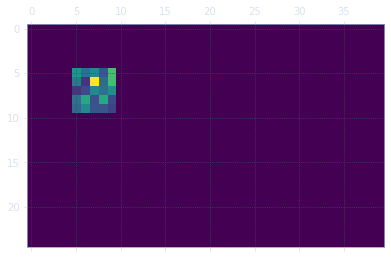

In [100]:
HS = get_HS_dirty(nrows=25, ncols=40, Delta=1.0, dirty_region=(5, 5, 10, 10), use_full_mtx=False, scale=8.0)
#HS = get_HS(nrows=25, ncols=40, Delta=1.0)
plot_system(HS, nrows=25, ncols=40)

In [76]:
HS.shape[0] == 4*nrows*ncols

True

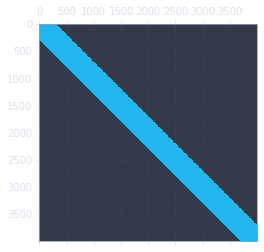

In [73]:
plt.spy(HS)

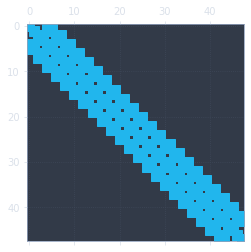

In [59]:
plt.spy( get_H0_col(nrows=12, Delta=2) )

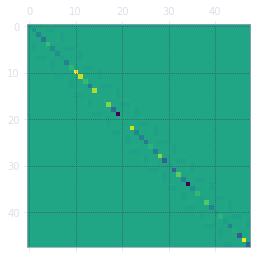

In [60]:
# Only diagonal elements are random
plt.matshow(np.real( 
    get_H0_col_dirty(nrows=12, Delta = 2, rows_dirty_from=4, rows_dirty_to=8, use_full_mtx=False, scale=8).toarray()
))

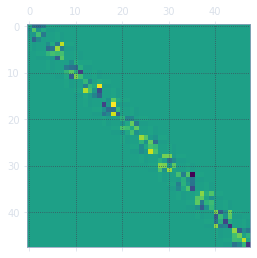

In [61]:
# The full matrix is random
plt.matshow(np.real( 
    get_H0_col_dirty(nrows=12, Delta = 2, rows_dirty_from=4, rows_dirty_to=8, use_full_mtx=True, scale=8).toarray()
))

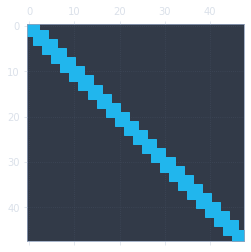

In [50]:
plt.spy( get_H1_cc(nrows=12) )

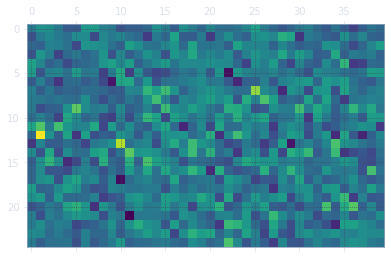

In [25]:
nrows = 25
ncols = 40
E = 0.0 # Energy level

HS = get_HS(nrows, ncols, Delta=2.0)
Heff = E*ss.eye(HS.shape[0]) - HS

# Calculate the surface Greens function
GS = sl.inv(Heff)

# Extract the system from G
dof = 4 # we have 4 degrees of freedom on each site
diags = np.diag(np.imag(GS.toarray())) # Each site corresponds to 4 diagonal elements
diags_reduced = [] # Each entry in this array will be associated with a single site
it = iter(diags)
while True:
    try:
        diags_reduced.append( np.sum([next(it) for k in range(dof)]) )
    except StopIteration:
        break
diags_reduced = np.array(diags_reduced)

# Build the matrix that corresponds to the system of nrow, ncols shape
it = iter(diags_reduced)
sys = np.zeros(shape=(nrows, ncols))
for i in range(ncols):
    for j in range(nrows):
        sys[j,i] = next(it)
        
plt.matshow( sys )

# Sandbox area

In [11]:
nA = 3
nB = 2
A = ss.kron(np.eye(nA), 7*sz)
B = ss.kron(np.eye(nB), 2*sz)

In [12]:
H = ss.bmat([[A, None], [None, B]]).toarray()
H

array([[ 7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -7.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -7.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.]])

In [13]:
LS = np.zeros(shape=(nA+nB, nA+nB))
LS[nA-1,nA]=1
LS[nA,nA-1]=1
LS = ss.kron(LS, 6*sx)
LS.toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 6., 0., 0.],
       [0., 0., 0., 0., 0., 0., 6., 0., 0., 0.],
       [0., 0., 0., 0., 0., 6., 0., 0., 0., 0.],
       [0., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
(H+LS)

matrix([[ 7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -7.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  6.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -7.,  6.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  6.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  6.,  0.,  0., -2.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.]])

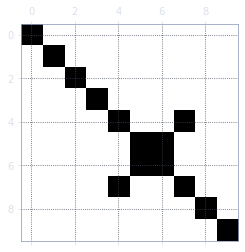

In [15]:
plt.spy(H+LS)

In [16]:
V = 6
nrowsdirty = 2
nrows=5
R1 = ss.kron(np.eye(nrowsdirty), V*s0)
R2 = ss.kron(np.eye(nrows-nrowsdirty), s0)
ss.bmat([[R2, None], [None, R1]]).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 6., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 6., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 6., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 6.]])

In [17]:
A = B = 2

In [18]:
def getA():
    A = 3\
    + 3\
    + 2
    return A

In [19]:
getA()

8

In [20]:
def f(k):
    s,b,x = k
    print(s,b,x)
f(k=(0,2,3))

0 2 3


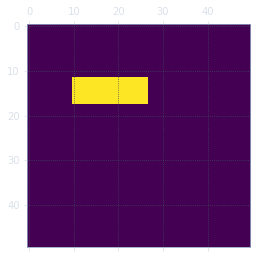

In [22]:
dirty_region = (12, 10, 18, 27)
A = np.zeros(shape=(50, 50))
i0, j0, i1, j1 = dirty_region

for row in range(i0, i1):
    for col in range(j0, j1):
        A[row, col] = 1.0
        
plt.matshow(A)

In [33]:
ss.block_diag([sz,1.2*sz]).toarray()

array([[ 1. ,  0. ,  0. ,  0. ],
       [ 0. , -1. ,  0. ,  0. ],
       [ 0. ,  0. ,  1.2,  0. ],
       [ 0. ,  0. ,  0. , -1.2]])

In [38]:
np.random.randn(4,4).shape

(4, 4)